In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 

In [4]:
dataname = "m4_weekly_id"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_id.


In [5]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])


In [6]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'item_id': 'W1',
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([1]),
 'source': SourceContext(source=Span(path=WindowsPath('C:/Users/TM/.mxnet/gluon-ts/datasets/m4_weekly_id/train/m4_weekly_id_train.json'), line=1), row=1)}

In [7]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='feat_static_cat' cardinality='359'>]

In [8]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['359']

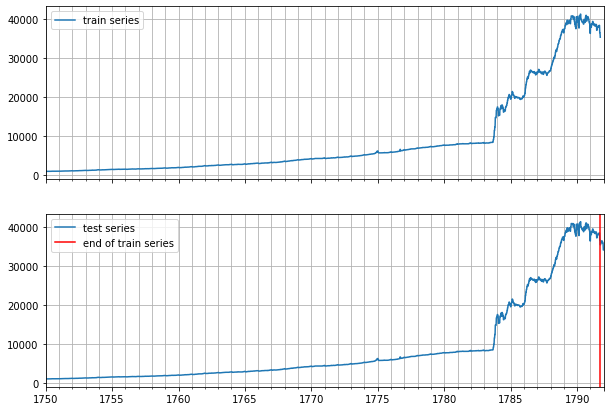

In [9]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [17]:
dataset = get_dataset("m4_weekly_id", regenerate=False)

epochs=500
num_batches = 100

mx.random.seed(43)
np.random.seed(43)

trainer = Trainer(
    ctx=mx.cpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
)

estimator = DeepAREstimator(
    trainer=trainer,
    cardinality= [
        feat_static_cat.cardinality 
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
#     context_length=dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True
)

predictor = estimator.train(training_data=dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_id.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 11.08it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[0] Elapsed time 9.057 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.626563
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.91it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[1] Elapsed time 6.712 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.808645
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.52it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[2] Elapsed time 6.893 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.608784
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.34it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 7.517 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.539

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.67it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[36] Elapsed time 11.543 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.873855
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.33it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[37] Elapsed time 12.034 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.882374
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.85it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[38] Elapsed time 10.166 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.924073
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.05it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[39] Elapsed time 9.961 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.953791
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.13it/s, avg_epoch_loss=5.86]

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.28it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[73] Elapsed time 8.874 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.758546
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.72it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 9.337 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.770684
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.68it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 9.372 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.762638
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.27it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[76] Elapsed time 8.883 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.764742
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.30it/s, avg_epoch_loss=5.8]
INF

100%|██████████| 100/100 [00:10<00:00,  9.98it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[109] Elapsed time 10.032 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.661047
INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:09<00:00, 10.98it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[110] Elapsed time 9.112 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.722698
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:09<00:00, 11.07it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[111] Elapsed time 9.044 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.676702
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.44it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[112] Elapsed time 8.749 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.673929
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.8

INFO:root:Epoch[144] Elapsed time 9.029 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=5.639752
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 12.64it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[145] Elapsed time 7.920 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=5.688026
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.41it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[146] Elapsed time 8.063 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.637664
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.72it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[147] Elapsed time 10.293 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.672050
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 12.55it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[148] Elapsed time 7.973 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.6

INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 11.00it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[181] Elapsed time 9.105 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.633595
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 11.05it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[182] Elapsed time 9.070 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.676692
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.42it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[183] Elapsed time 8.768 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.658170
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.22it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[184] Elapsed time 8.926 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.679229
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.51it/s, avg_epoch_

INFO:root:Epoch[217] Elapsed time 7.746 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=5.645969
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  9.06it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[218] Elapsed time 11.059 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=5.633692
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.76it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[219] Elapsed time 11.422 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.683739
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.62it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[220] Elapsed time 9.424 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.656879
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.22it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[221] Elapsed time 9.793 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.

INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.44it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[254] Elapsed time 8.760 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=5.667082
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.33it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[255] Elapsed time 8.113 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.608400
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.39it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[256] Elapsed time 8.078 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.669435
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.78it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[257] Elapsed time 11.401 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.642313
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.06it/s, avg_epoch

INFO:root:Epoch[290] Elapsed time 8.419 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=5.619559
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.36it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[291] Elapsed time 7.503 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=5.663000
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.25it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[292] Elapsed time 7.554 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.604825
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 12.56it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[293] Elapsed time 7.969 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.617433
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.18it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[294] Elapsed time 8.214 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.641

INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.35it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[327] Elapsed time 8.100 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=5.636268
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.26it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[328] Elapsed time 7.545 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.609084
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 12.72it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[329] Elapsed time 7.864 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.636357
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.04it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[330] Elapsed time 7.670 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.575191
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.17it/s, avg_epoch_

INFO:root:Epoch[363] Elapsed time 14.325 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=5.669536
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.21it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[364] Elapsed time 7.604 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=5.647919
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.24it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[365] Elapsed time 7.554 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.621452
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.82it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[366] Elapsed time 7.235 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.638972
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.03it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[367] Elapsed time 7.159 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.6

INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.38it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[400] Elapsed time 13.559 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=5.594139
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[401] Elapsed time 8.715 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=5.638538
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.43it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[402] Elapsed time 8.755 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.591321
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.59it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[403] Elapsed time 8.635 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.648885
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.51it/s, avg_epoch

INFO:root:Epoch[436] Elapsed time 7.052 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=5.622653
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.61it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[437] Elapsed time 7.349 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=5.629883
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.33it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[438] Elapsed time 6.987 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=5.647156
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.12it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[439] Elapsed time 7.081 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.581839
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.09it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[440] Elapsed time 7.111 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.61

INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.24it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[473] Elapsed time 7.038 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=5.565541
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.32it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[474] Elapsed time 7.003 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=5.599659
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.51it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[475] Elapsed time 6.896 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=5.609634
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.52it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[476] Elapsed time 6.902 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.625917
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.42it/s, avg_epoch_l

In [18]:
metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

pd.DataFrame([output])

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9]
0,2.591025,0.082941,23.546545,0.061609,0.028087


In [19]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,W1,471639.653846,7742.027344,464329.437500,35717.649038,63.683045,9.351635,0.016724,37.178395,4254.310938,...,7742.027344,0.230769,6975.718750,0.307692,5431.164844,0.461538,3649.306250,0.538462,1901.535937,1.000000
1,W2,6475.826923,950.027588,46501.820312,3577.063101,12.059746,6.059750,0.020572,24.327849,412.029443,...,950.027588,0.230769,856.271094,0.307692,693.328613,0.461538,500.246484,0.615385,284.894238,0.923077
2,W3,113789.471154,3812.056641,128300.796875,9869.292067,33.355166,8.791296,0.030140,97.901545,1424.963867,...,3812.056641,0.076923,3702.284375,0.076923,3326.847266,0.153846,2713.234766,0.230769,1752.564648,0.384615
3,W4,55698.427885,2578.138428,38126.421875,2932.801683,353.363468,0.561230,0.068674,2.516701,1480.185840,...,2578.138428,0.153846,2356.283398,0.230769,1890.698535,0.538462,1505.949902,0.769231,832.020166,1.000000
4,W5,24903.247596,1655.095581,23475.000000,1805.769231,705.777154,0.180390,0.068996,1.059934,1162.928101,...,1655.095581,0.384615,1431.830713,0.384615,1025.365039,0.769231,960.311084,0.846154,782.072607,1.000000


In [20]:
item_metrics.to_csv("m4_weekly_deepar_metrics_owa0919.csv")